# 大作业 基于VAE的手写数字生成
- 姓名：马永田 齐传辉
- 学号：2012911 2012909
- 专业：计算机科学与技术专业

## 实验要求：
- 基本要求：利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字；
- 中级要求：实现VAE的变分推断(最好是手写推导)，描述VAE的由来以及优缺点；
- 提高要求：实现任意形式的对VAE进行改进或创新，例如：和其他网络结合或对比（图卷积神经网络(GCN)，生成对抗网络(GAN)，Diffusion Model等）；实现VAE的变种（β-VAE，β-TCVAE等）；修改数据集（例如加噪点，加mask等）以发掘VAE更多的功能；对可视化方法进行创新（例如输出隐变量）……


### 基本要求

In [3]:
# 需要提前安装Pytorch和对应版本的torchvision
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [4]:
# 下载数据集
dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
batch_sz = 128   # 数据集切分，每个batch大小为128
dataIter = Data.DataLoader(dataset, batch_size=batch_sz, shuffle=True)

In [6]:
# 查看张量的维度数：N(num),C(channel),H(height),W(width)
x, y = next(iter(dataIter))
x.shape  # torch.Size([128, 1, 28, 28]), 表示每个batch有128张图，只有一个channel(黑白)，长宽分别是28*28

torch.Size([128, 1, 28, 28])

In [2]:
# 展平
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)   # torch.Size([128, 784])

In [7]:
# 简单建一个VAE
class VAE(nn.Module):
    def __init__(self, count_size = 784, h_dim=256, z_dim=20):  
        # 输入维度是784，中间Encoder、Decoder的维度是256，隐变量维度是20
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(count_size, h_dim)  # Encoder
        self.fc2 = nn.Linear(h_dim, z_dim)  # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim)  # 方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)  # Decoder
        self.fc5 = nn.Linear(h_dim, count_size)  # output
    

    # 编码
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    # 重参数化生成隐变量
    def reparameterize(self, mu, log_var):      
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std    

    # 解码
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var 



In [8]:
# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
learning_rate = 10e-4  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差
for epoch in range(epoches):
    for i, (x, y) in enumerate(dataIter):
        # 展平并训练
        x = flatten(x).to(device)
        x_reconst, mu, log_var = model(x)
        
        # 计算损失函数(交叉熵损失 (Cross Entropy Loss) )
        reconst_loss = F.cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # 反向传播和优化
        loss = reconst_loss+kl_div
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 输出batch信息
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch+1, i, loss.cpu().item()/len(x)))
        train_loss[epoch]=train_loss[epoch]+loss
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch+1, epoches, train_loss[epoch] / len(dataIter.dataset)))

e:\py\anaconda\ana3\envs\ml\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
e:\py\anaconda\ana3\envs\ml\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch : 1 | #batch : 200 | batch average loss: 640.3668823242188
epoch : 1 | #batch : 400 | batch average loss: 629.6751708984375
epoch[1/20] | loss:638.434814453125
epoch : 2 | #batch : 200 | batch average loss: 612.6016235351562
epoch : 2 | #batch : 400 | batch average loss: 630.299560546875
epoch[2/20] | loss:633.8345947265625
epoch : 3 | #batch : 200 | batch average loss: 643.8195190429688
epoch : 3 | #batch : 400 | batch average loss: 631.0142822265625
epoch[3/20] | loss:633.0025634765625
epoch : 4 | #batch : 200 | batch average loss: 627.2196044921875
epoch : 4 | #batch : 400 | batch average loss: 667.1210327148438
epoch[4/20] | loss:632.7636108398438
epoch : 5 | #batch : 200 | batch average loss: 663.71484375
epoch : 5 | #batch : 400 | batch average loss: 649.8168334960938
epoch[5/20] | loss:632.6508178710938
epoch : 6 | #batch : 200 | batch average loss: 666.1262817382812
epoch : 6 | #batch : 400 | batch average loss: 621.0939331054688
epoch[6/20] | loss:632.5431518554688
epoch

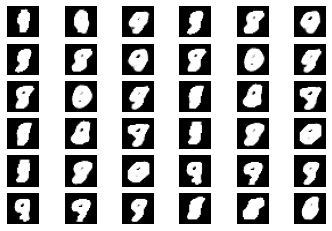

In [9]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

In [16]:
learning_rate = 10e-4  # 学习率
epoches = 20  # 迭代20次
# 实例化一个模型
model = VAE().to(device)

# 创建优化器
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差
for epoch in range(epoches):
    for i, (x, y) in enumerate(dataIter):
        # 展平并训练
        x = flatten(x).to(device)
        x_reconst, mu, log_var = model(x)
        
        # 计算损失函数(L2损失 (MSE Loss))
        reconst_loss = F.mse_loss(x_reconst, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # 反向传播和优化
        loss = reconst_loss+kl_div
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 输出batch信息
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch+1, i, loss.cpu().item()/len(x)))
        train_loss[epoch]=train_loss[epoch]+loss
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch+1, epoches, train_loss[epoch] / len(dataIter.dataset)))

epoch : 1 | #batch : 200 | batch average loss: 0.0002543026057537645
epoch : 1 | #batch : 400 | batch average loss: 0.00017018977086991072
epoch[1/20] | loss:0.0003081164322793484
epoch : 2 | #batch : 200 | batch average loss: 0.0001321164018008858
epoch : 2 | #batch : 400 | batch average loss: 0.00012629867705982178
epoch[2/20] | loss:0.00013102515367791057
epoch : 3 | #batch : 200 | batch average loss: 0.00010209064930677414
epoch : 3 | #batch : 400 | batch average loss: 0.00010215076326858252
epoch[3/20] | loss:0.00010625649883877486
epoch : 4 | #batch : 200 | batch average loss: 8.652172982692719e-05
epoch : 4 | #batch : 400 | batch average loss: 9.499581210548058e-05
epoch[4/20] | loss:9.570375550538301e-05
epoch : 5 | #batch : 200 | batch average loss: 8.946946036303416e-05
epoch : 5 | #batch : 400 | batch average loss: 8.648719085613266e-05
epoch[5/20] | loss:8.882598194759339e-05
epoch : 6 | #batch : 200 | batch average loss: 8.70581716299057e-05
epoch : 6 | #batch : 400 | batc

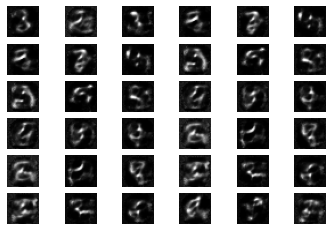

In [17]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

经过多次测试，当我们仅将交叉熵和L2作为损失函数时，L2的表现明显优于交叉熵函数，但当我们加入KL散度后进行测试，发现交叉熵的效果优于L2。

### 中级要求

<img src =image/1.jpg>
<img src =image/2.jpg>
<img src =image/3.jpg >

#### VAE的由来
假设有一个目标数据X={X1,X2,⋯,Xn},我们想生成一些数据，即生成X^={X1^,X2^,⋯,Xn^},其分布与X相同。

​   但是实际上，这样存在一些问题，第一是我们如何将生成的X^与X一一对应，这就需要我们采用更为精巧的度量方式，即如何度量两个分布之间的距离；第二是我们如何生成新的X^,按照朴素的想法，我们可以构造一个函数G，使得X^=G(Z) ,如果能构造出这个G,我们就可以通过一个任意的Z,来生成X^ ,而这里的Z,可以取一个已知的分布，比如正态分布。

​问题即转化为了如何构造G,以及如何检验我们生成的X^是否和X具有同分布。沿着AutoEncoder的想法，AutoEncoder是通过encoder把image a编码为vector,叫做latent represention ,再通过decoder将latent space转为a^ ,a^为a的重建图像。

​   但是AE针对每张图片生成的latent code并没有可解释性，即sample两个latent code之间的点输入decoder,得到的结果并不一定具有跟这两个latentcode相关的特征。为了解决这个问题，有人提出了VAE：不再采用vector来建模一个latent code,而是利用一个带有noise的高斯分布来表示。直观的理解，在加入noise之后，就有机会将训练时候train的latent code在其latent space下赋予一定的变化能力，使latent space变得更加连续，从而可以在其中采样从而生成新的图片。

​   我们之前生成的Z={Z1,Z2,⋯,Zn},现在不再单单生成一个Z,而是生成两个vector，分别记为M={μ1,μ2,⋯μn},Σ={σ1,σ2,⋯,σn},分别代表新生成latent code的高斯分布的均值和方差。在sample的时候就只需要根据从标准正态分布N(0,1)中采样一个ei,ei来自于E={e1,e2,⋯,en},然后利用ci=ei∗exp(σi)+μi(reparameterization trick)，就得到了我们所需的ci ，ci即组成我们需要的Z={c1,c2,⋯,cn}。

​   这里一方面希望VAE能够生成尽可能丰富的数据，因此训练的时候希望在高斯分布中含有噪声。另一方面优化的过程中会趋向于使图像质量更好，因此当噪声为0的时候退化为普通的AutoEncoder，这种情况我们是不希望出现的。为了平衡这种trade-off，这里希望每个p(Z|X)能够接近标准正态分布，但是另一方面网络又趋于使输入和输出图像更为接近，因此会使正态分布的方差向0的方向优化。经过这种对抗过程，最终就能产生具有一定可解释性的decoder,同时最终得到的Z的分布也会趋向于N(0,1)，可以表示为：

​
                                p(Z)=∑Xp(Z∣X)p(X)=∑XN(0,1)p(X)=N(0,I)∑Xp(X)=N(0,1)
#### VAE的优点

- 可对数据进行低维表征学习
- 对似然的精确近似
- 可插值生成结果，可了解模型学习到了什么
- 解纠缠表征
- VAE拥有以下特质：
  - 生成式模型
  - 密度模型
  - 隐变量模型
  - 可对数据降维

VAE可以通过编码解码的步骤，直接比较重建图片和原始图片的差异。对于每个隐性参数VAE不会去只生成固定的一个数，而是会产生一个置信分布区间，这是一种连续的表达方式，通过采样，我们就可以获得许多从来没有见过的数据。

#### VAE的缺点

- 生成结果模糊
- 后验分布被假设为可分解的高斯分布(协方差为对角阵)，以及解码器假设太强
- 生成更大规模结果(生成大尺寸图像)仍有待研究
- 运用KL散度对解纠缠进行研究，目前仍处于研究简单示例的阶段
- 也许还有更好的表示学习方法，或者能得到更好的样本，或者能得到更好的概率密度估计

VAE实际上并没有去学怎么产生一张新的像真的的图片，而是学习怎么产生一张图片能与database里的图片一模一样，只是模仿而已。直接计算生成图片和原始图片的均方误差而不是像GAN那样去对抗来学习，这就使得生成的图片会有点模糊。

### 高级要求

实现了β-VAE，同时实现了对隐变量z可视化为热力图并输出

In [7]:
# β-VAE
class bate_VAE(nn.Module):
    def __init__(self, count_size = 784, h_dim=256, z_dim=20):  
        # 输入维度是784，中间Encoder、Decoder的维度是256，隐变量维度是20
        super(bate_VAE, self).__init__()
        self.fc1 = nn.Linear(count_size, h_dim)  # Encoder
        self.fc2 = nn.Linear(h_dim, z_dim)  # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim)  # 方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)  # Decoder
        self.fc5 = nn.Linear(h_dim, count_size)  # output
    

    # 编码
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
        
    # 重参数化生成隐变量
    def reparameterize(self, mu, log_var):      
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std    

    # 解码
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var ,z

epoch : 1 | #batch : 200 | batch average loss: 142.5398712158203
epoch : 1 | #batch : 400 | batch average loss: 125.64264678955078
epoch[1/20] | loss:156.04798889160156
[[ 0.516579    0.18504886 -1.5957382  ... -0.22989054 -1.3818345
  -0.17543367]
 [ 2.5055559   0.95408833 -0.46030986 ...  0.13747652 -0.55455154
  -0.4227925 ]
 [-0.8317953   0.04201603  0.40030217 ... -1.6599746   0.73445386
  -0.05218025]
 ...
 [-0.22407344 -1.2540932  -1.1108582  ... -0.34689504 -0.74579704
   1.3208066 ]
 [ 0.46239614  2.866123   -0.18648002 ... -0.12545265 -1.7606095
  -1.3804393 ]
 [-1.6104271  -0.80991256  0.42010644 ...  0.7847153  -0.6369889
   0.5834755 ]]


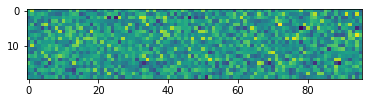

epoch : 2 | #batch : 200 | batch average loss: 119.01374816894531
epoch : 2 | #batch : 400 | batch average loss: 124.36973571777344
epoch[2/20] | loss:123.81888580322266
[[ 0.1537915  -0.0739681  -0.35211793 ...  0.13274717  1.4172723
  -0.28726214]
 [-0.16386306  1.1601892   1.8812597  ...  0.2120061   0.51120377
  -0.07204477]
 [ 1.4907169   0.5077625   0.8073912  ... -0.7460437  -0.8245704
   0.00871504]
 ...
 [-0.5929011   1.5087421   1.1612018  ...  0.7010744  -0.09216896
   0.67530406]
 [-1.0142175   0.41056055  0.47152635 ... -1.4264065  -0.4216797
  -0.20045827]
 [ 0.01532733  0.72855616 -1.9096092  ...  0.7990855   0.43140912
  -0.08818363]]


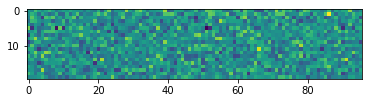

epoch : 3 | #batch : 200 | batch average loss: 119.89244079589844
epoch : 3 | #batch : 400 | batch average loss: 119.83480834960938
epoch[3/20] | loss:120.64915466308594
[[ 0.2266525  -0.7356397  -0.25522178 ...  0.240915   -0.14540565
   0.33363563]
 [ 1.0005451  -0.27529657 -0.13440454 ... -0.06572839  0.01030795
  -1.4593158 ]
 [-1.2579043  -1.2544129  -0.117917   ...  1.1377     -1.5763586
   1.2092369 ]
 ...
 [ 1.2127485  -0.71854687  0.70056206 ... -0.9173428  -0.02433418
   1.8712305 ]
 [ 0.09596188 -0.31070697  0.06293924 ... -1.735507    0.06843145
   0.1662119 ]
 [ 1.2659036   0.25432646 -0.2068501  ...  0.9336218   0.54495865
  -1.1245747 ]]


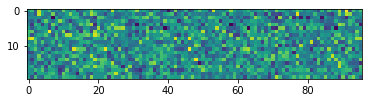

epoch : 4 | #batch : 200 | batch average loss: 121.55562591552734
epoch : 4 | #batch : 400 | batch average loss: 118.4819107055664
epoch[4/20] | loss:118.98858642578125
[[ 0.01282752 -0.622002    0.57310647 ... -1.6663486  -0.9964855
   0.33086932]
 [ 0.11608323 -0.9594015   0.23084334 ... -1.256029    0.27275345
   1.0776994 ]
 [-0.11497978  0.23337376 -0.46697405 ...  0.96165216 -0.2750135
  -0.9195149 ]
 ...
 [-0.16056968 -1.1481601   1.4341981  ... -0.06890371  0.6173146
  -0.23303553]
 [ 0.68391794 -0.8479853   1.1606905  ...  0.5533973  -0.14202046
   0.65823877]
 [-0.07638612 -0.97869587 -0.8558221  ...  1.2082018  -1.4473728
   0.15228686]]


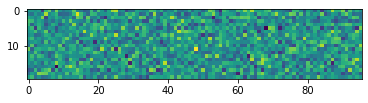

epoch : 5 | #batch : 200 | batch average loss: 122.30752563476562
epoch : 5 | #batch : 400 | batch average loss: 120.39158630371094
epoch[5/20] | loss:118.10164642333984
[[ 0.34715247  1.9924215  -0.16346963 ...  0.9795843   0.6028786
   1.2581015 ]
 [ 1.6030941  -0.33962837 -0.91053456 ... -0.77817893  1.506594
  -1.5595206 ]
 [-0.2481803   2.9446144   0.47472087 ...  0.8217474   1.4320745
  -0.49797058]
 ...
 [ 0.26056856 -0.35242903  0.1179373  ...  0.21388876 -0.525067
  -0.06168019]
 [-1.2948885   0.00994441 -0.35481033 ... -0.18901928  0.34050488
  -1.1862236 ]
 [ 0.81742436 -1.6574237   0.35682297 ... -0.04479612  1.1508324
  -0.22101009]]


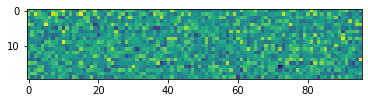

epoch : 6 | #batch : 200 | batch average loss: 116.92584228515625
epoch : 6 | #batch : 400 | batch average loss: 120.14195251464844
epoch[6/20] | loss:117.45724487304688
[[-0.32025903 -0.9297954  -0.4193688  ...  0.59385735 -1.2912958
  -1.078809  ]
 [-0.58294713  1.9944094   0.4222201  ...  0.5154047  -0.42999274
   1.1754993 ]
 [-0.9730543  -0.20038664  2.0814233  ...  0.60297585  0.77066696
   0.748465  ]
 ...
 [-1.5923505   0.90181315  0.7489223  ... -1.4475597   1.1167983
   1.0313151 ]
 [-0.00905295 -1.1920891  -0.10234348 ... -1.176439   -0.8673729
  -0.67875916]
 [-0.41036767 -0.74390674  0.15759139 ...  0.8289303   1.872141
  -0.87579256]]


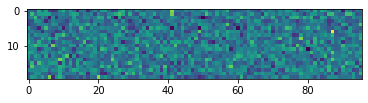

epoch : 7 | #batch : 200 | batch average loss: 121.17081451416016
epoch : 7 | #batch : 400 | batch average loss: 113.91423034667969
epoch[7/20] | loss:117.09086608886719
[[-1.0541363   0.2734703   0.07221542 ...  0.8008319  -2.6268933
   1.6114568 ]
 [-0.7313224  -0.14040488  0.50497645 ... -0.56614035  0.7583722
  -1.2700038 ]
 [-0.558311    2.4081247  -0.09231752 ... -0.353298   -0.50215846
  -0.7280884 ]
 ...
 [-0.3961308   0.20489179  0.53161836 ... -0.41611046 -0.26711074
   0.2487812 ]
 [ 0.9860829  -1.4757375   0.5053325  ...  0.0194631   0.78748035
   0.9636537 ]
 [-0.7611234   0.08021069 -0.17654589 ...  0.70098186 -1.1521928
   1.710499  ]]


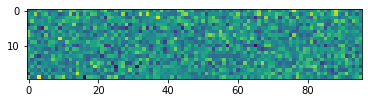

epoch : 8 | #batch : 200 | batch average loss: 118.18521881103516
epoch : 8 | #batch : 400 | batch average loss: 121.3599853515625
epoch[8/20] | loss:116.77365112304688
[[-0.9714476   1.7230551   0.21763964 ... -1.5887214   0.8180336
  -1.0194659 ]
 [ 0.6752487  -0.9891899   1.566827   ... -0.8914824   1.0592973
  -1.3628448 ]
 [-0.9751437  -0.09432205  0.335082   ...  0.02150122  1.1643296
  -0.03488949]
 ...
 [-0.28752038  0.5369487   0.0130059  ...  0.2559293   0.48980257
  -0.16336158]
 [-0.607561   -0.7336471  -0.56144005 ...  0.9683785  -0.02406552
   0.5726739 ]
 [ 0.6813971  -0.9264547  -1.3901905  ... -1.3341084  -0.04280736
  -1.5000745 ]]


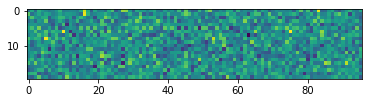

epoch : 9 | #batch : 200 | batch average loss: 113.87462615966797
epoch : 9 | #batch : 400 | batch average loss: 122.09652709960938
epoch[9/20] | loss:116.30480194091797
[[-1.6685714   1.0778952  -0.5948899  ...  1.3202722   0.6674745
   0.34992036]
 [-0.73123956 -1.813593    0.29195878 ... -0.41181588 -0.24654216
   0.5518719 ]
 [ 0.47368014 -1.3290714   0.4301864  ... -1.8778985   0.04483095
   1.6931201 ]
 ...
 [ 1.81179     1.2369995  -1.6341774  ...  1.1907973  -0.15126075
   0.325045  ]
 [-0.91051894  1.51641    -0.08789301 ... -1.0090523   0.9239749
  -1.6015208 ]
 [-0.24656078  0.18608408  1.815681   ...  1.4175024   0.67970896
  -1.4570484 ]]


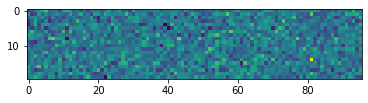

epoch : 10 | #batch : 200 | batch average loss: 114.74980163574219
epoch : 10 | #batch : 400 | batch average loss: 118.35871887207031
epoch[10/20] | loss:116.09884643554688
[[ 1.5223886   1.5887202  -1.8628752  ...  1.1305051  -1.2837163
   1.9044989 ]
 [ 0.32827377  0.31364828  0.535645   ... -1.9424567   0.12886424
   0.09819908]
 [ 1.3068922  -0.37782782 -0.24864382 ... -2.819263    0.8336721
  -0.08459509]
 ...
 [-0.24688101  1.2002677  -1.8664424  ...  0.92414105  0.1271015
   0.5587318 ]
 [-0.35596365 -0.22777061  0.12175848 ... -0.0051259   0.08571593
  -1.3957746 ]
 [-0.9288345   1.7258906   0.1845817  ... -1.3212368   1.3495573
   0.8730029 ]]


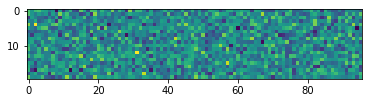

epoch : 11 | #batch : 200 | batch average loss: 120.19330596923828
epoch : 11 | #batch : 400 | batch average loss: 116.86116027832031
epoch[11/20] | loss:115.84967041015625
[[-1.1446916  -0.5039768   0.6628077  ... -0.9794711   2.3281016
  -0.69075626]
 [ 3.408203    0.9974571  -0.23094264 ...  0.80066514  0.8247373
  -0.3684686 ]
 [ 0.57572824 -1.3864526   1.2280555  ... -0.16479945  0.5849544
   0.70741135]
 ...
 [ 0.22810882 -1.3906815  -0.49432698 ...  0.49327466 -1.2188237
   1.6880921 ]
 [ 1.1282402  -0.10982384  0.8191234  ... -1.7409225  -0.8109487
  -0.26397496]
 [ 0.5802834  -0.31938475  1.5563242  ...  0.9024466   1.5655868
  -0.10073288]]


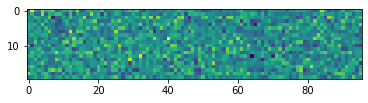

epoch : 12 | #batch : 200 | batch average loss: 117.12670135498047
epoch : 12 | #batch : 400 | batch average loss: 115.95046997070312
epoch[12/20] | loss:115.7471694946289
[[-0.9632723  -1.1271522   0.13154902 ...  0.16182315 -1.0868115
  -0.39466536]
 [-0.7972753   0.4181646   0.10521224 ... -0.9347643  -0.2539919
  -0.25918686]
 [ 0.63889676 -0.10727928 -0.23585011 ... -0.6373695  -0.49215996
   0.63406336]
 ...
 [ 1.696287    2.9780138  -0.12173226 ...  0.8990607  -0.05483346
   0.35487568]
 [-0.65665144 -1.4400072  -0.17399478 ... -0.33126694 -0.22103289
  -0.221791  ]
 [ 1.2137971   2.156796    0.75343883 ...  0.3999939   2.7610228
  -0.14508435]]


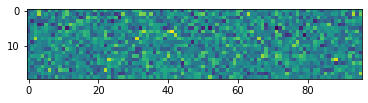

epoch : 13 | #batch : 200 | batch average loss: 111.8803482055664
epoch : 13 | #batch : 400 | batch average loss: 116.31634521484375
epoch[13/20] | loss:115.60376739501953
[[ 0.07595258  0.42931864 -0.15062967 ...  0.7618944   1.4415586
  -0.37074792]
 [ 0.6629832  -0.36651435 -0.41823775 ...  0.9468063   1.5184759
   1.3436499 ]
 [-0.02526519 -0.11772447  0.7964468  ...  0.778116   -1.3026944
  -1.7034748 ]
 ...
 [-0.45934004  0.28743863  0.14360479 ...  1.5846249  -0.44250396
  -0.09716162]
 [ 0.48591793  0.453966   -1.6877086  ...  1.3464509  -1.6142104
  -1.3759087 ]
 [ 0.6881832  -1.7832953   0.31990343 ... -0.73276913  1.0105625
  -0.09910572]]


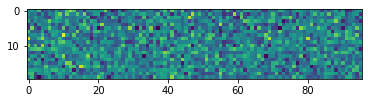

epoch : 14 | #batch : 200 | batch average loss: 110.14544677734375
epoch : 14 | #batch : 400 | batch average loss: 115.90505981445312
epoch[14/20] | loss:115.39732360839844
[[-0.7384864  -0.7449324   0.82260716 ...  0.9249262  -0.9230246
   1.3193784 ]
 [-1.1581634   1.6961412  -2.8330438  ...  2.0474927  -0.8431397
  -1.082973  ]
 [-0.66926813  0.5791072  -0.29631525 ... -0.4756093   1.7363344
   0.15825488]
 ...
 [ 0.16781652 -1.2728729  -0.5676173  ... -1.3045918  -0.42436677
   1.4609113 ]
 [ 1.3169861  -1.6591778   0.48299116 ...  0.24168774  0.00545468
   0.9290575 ]
 [ 0.27186954 -0.95573306 -0.44079885 ...  0.5311178  -2.2017589
   0.41507566]]


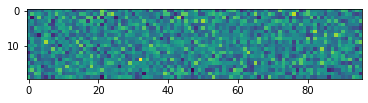

epoch : 15 | #batch : 200 | batch average loss: 116.66641235351562
epoch : 15 | #batch : 400 | batch average loss: 118.736572265625
epoch[15/20] | loss:115.43863677978516
[[-0.8951483  -0.74599195  0.6604193  ... -0.8412199   1.3341246
  -0.6351384 ]
 [ 0.74051744 -1.5730941  -0.8157297  ... -1.048129    0.02948872
  -0.58750457]
 [-0.33381605  0.87796557 -0.03666779 ... -1.1859941  -0.5276236
   1.8484132 ]
 ...
 [-0.35059342 -0.33649796 -0.4175302  ...  0.4417162   0.07359099
  -1.2440816 ]
 [-0.61314106 -1.6367719   0.4728271  ...  0.31878597 -0.24141319
  -0.6369972 ]
 [ 2.4898033   1.1659132  -0.87579197 ...  1.186093   -0.52195144
   0.41184157]]


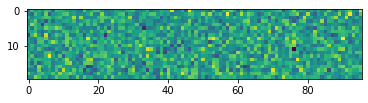

epoch : 16 | #batch : 200 | batch average loss: 119.3868637084961
epoch : 16 | #batch : 400 | batch average loss: 115.16023254394531
epoch[16/20] | loss:115.38273620605469
[[-0.2393458   0.7549931  -0.56626326 ... -0.3365815  -0.78207475
  -0.15365323]
 [ 0.16872524 -0.15055713 -1.456516   ... -2.4336734   1.6960331
  -1.6903944 ]
 [-0.85860884 -0.02898029  0.59110636 ... -1.6853365  -0.9575101
  -0.37656683]
 ...
 [-0.37934083  1.1802574  -0.9030101  ...  2.1285412   1.3359374
   0.27959296]
 [ 1.1748472  -1.5445029   0.96651345 ...  1.7412924   0.36811635
   1.2160984 ]
 [-0.27713075 -1.2603097  -0.5037103  ...  0.24812499  2.3360841
   0.37783676]]


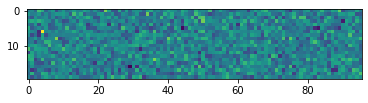

epoch : 17 | #batch : 200 | batch average loss: 111.5522689819336
epoch : 17 | #batch : 400 | batch average loss: 118.05302429199219
epoch[17/20] | loss:115.0677261352539
[[ 0.46019396  0.33377564 -1.3015784  ...  1.1571995  -0.15967742
  -2.525836  ]
 [ 0.28161553 -1.4468307   0.42936087 ... -0.09173441  0.8979634
   0.29176673]
 [-0.13359787 -0.34123138  0.37904498 ... -0.6221502   2.4010584
  -1.4204481 ]
 ...
 [ 0.66118586 -0.28568566 -0.2781711  ...  0.35585845 -0.32084736
   0.18894151]
 [-0.5942657   0.68336993 -0.44188952 ... -1.1973112  -2.0083778
   1.2846591 ]
 [ 3.355137   -1.5909947  -0.85438764 ... -1.686039    0.9264688
   1.1896942 ]]


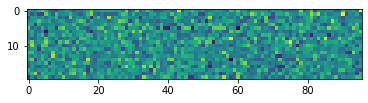

epoch : 18 | #batch : 200 | batch average loss: 115.34107208251953
epoch : 18 | #batch : 400 | batch average loss: 115.91585540771484
epoch[18/20] | loss:115.03488159179688
[[-0.44851792 -1.1849713   0.27248883 ... -1.0997337   0.14070389
   0.42540848]
 [-2.1119294   0.1148625  -0.866558   ...  0.6202362   1.3821734
   1.2609258 ]
 [ 0.7449621  -1.6994529   0.7805675  ...  0.09022343  0.2822228
   0.7702476 ]
 ...
 [-0.93848187 -1.2285923  -0.6578394  ...  1.004472   -0.3939761
   1.489109  ]
 [ 0.7460963   1.5907476   1.0669236  ... -1.015017   -0.49225682
   0.60264695]
 [ 1.3527943   0.92760783 -1.5145221  ...  0.44455707 -2.3627446
   0.5651897 ]]


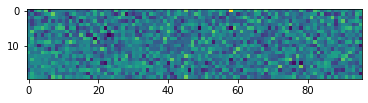

epoch : 19 | #batch : 200 | batch average loss: 111.39517211914062
epoch : 19 | #batch : 400 | batch average loss: 117.36846923828125
epoch[19/20] | loss:114.97101593017578
[[-0.35117933  0.48004478 -0.29968235 ...  0.47528505  1.7126194
   0.5477721 ]
 [-0.5156334  -0.02429374 -0.7941451  ... -0.13752376 -1.009396
  -1.2238588 ]
 [ 0.41659862 -0.9414119   0.3733456  ... -1.0085636   0.11277332
  -0.44318277]
 ...
 [-0.22710608 -0.4497303  -0.7928322  ... -1.9261091   0.91184175
  -0.94490033]
 [-0.06540196 -0.65878224  0.8056367  ...  1.0903221   0.73072577
  -0.25361034]
 [-1.5548191  -0.642501   -1.4106249  ...  1.1390123  -1.1727529
  -0.0146643 ]]


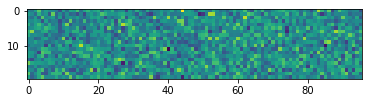

epoch : 20 | #batch : 200 | batch average loss: 113.4287109375
epoch : 20 | #batch : 400 | batch average loss: 118.5114974975586
epoch[20/20] | loss:114.95958709716797
[[ 1.9227368  -2.1680663  -0.71952194 ... -0.14668989  0.4261337
   0.9426493 ]
 [-0.2474994  -1.2070999   1.7479038  ...  0.6366154   1.5562445
  -1.0678828 ]
 [ 0.5982747  -1.1079067  -0.564965   ... -0.4881438  -0.9851259
  -0.34031415]
 ...
 [-0.34307885 -1.7416147   0.09314722 ... -1.1099044  -0.21324027
   0.238669  ]
 [ 0.30302584 -1.4737196   0.51017606 ...  0.17790271 -0.8776145
  -0.39845204]
 [-1.7833674   0.08460761 -0.19497992 ...  1.2053993   0.9834936
  -0.45400512]]


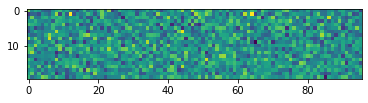

In [17]:
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
kl_weight=1
# 实例化一个模型
model = bate_VAE().to(device)

# 创建优化器
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差
for epoch in range(epoches):
    for i, (x, y) in enumerate(dataIter):
        # 展平并训练
        x = flatten(x).to(device)
        x_reconst, mu, log_var, z = model(x)
        
        # 计算损失函数(L2损失 (MSE Loss))
        reconst_loss = F.binary_cross_entropy(x_reconst, x , reduction="sum")
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # 反向传播和优化
        loss = reconst_loss+kl_weight*kl_div
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 输出batch信息
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch+1, i, loss.cpu().item()/len(x)))
        train_loss[epoch]=train_loss[epoch]+loss
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch+1, epoches, train_loss[epoch] / len(dataIter.dataset)))
    x1 = z.detach().cpu().numpy()
    img=np.transpose(x1)
    print(x1)
    plt.imshow(img)
    plt.show()

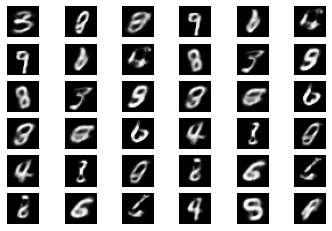

In [18]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()